In [1]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 78.8 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3


## Local Inference on GPU 
Model page: https://huggingface.co/Salesforce/blip-image-captioning-base

⚠️ If the generated code snippets do not work, please open an issue on either the [model repo](https://huggingface.co/Salesforce/blip-image-captioning-base)
			and/or on [huggingface.js](https://github.com/huggingface/huggingface.js/blob/main/packages/tasks/src/model-libraries-snippets.ts) 🙏

In [3]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")

2025-07-07 07:04:27.593312: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751871868.035583      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751871868.155069      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [2]:
from huggingface_hub import login
login(new_session=False)

In [4]:
from datasets import load_dataset

ds = load_dataset("UCSC-VLAA/MedTrinity-25M", "25M_demo")

README.md:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/51 [00:00<?, ?it/s]

train-00000-of-00010.parquet:   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00001-of-00010.parquet:   0%|          | 0.00/764M [00:00<?, ?B/s]

train-00002-of-00010.parquet:   0%|          | 0.00/721M [00:00<?, ?B/s]

train-00003-of-00010.parquet:   0%|          | 0.00/770M [00:00<?, ?B/s]

train-00004-of-00010.parquet:   0%|          | 0.00/791M [00:00<?, ?B/s]

train-00005-of-00010.parquet:   0%|          | 0.00/815M [00:00<?, ?B/s]

train-00006-of-00010.parquet:   0%|          | 0.00/909M [00:00<?, ?B/s]

train-00007-of-00010.parquet:   0%|          | 0.00/934M [00:00<?, ?B/s]

train-00008-of-00010.parquet:   0%|          | 0.00/853M [00:00<?, ?B/s]

train-00009-of-00010.parquet:   0%|          | 0.00/915M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/161630 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/18 [00:00<?, ?it/s]

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'id', 'caption'],
        num_rows: 161630
    })
})

In [7]:
img = ds["train"][0]["image"]
pipe(img)[0]['generated_text']

'the brain is shown in green and the left side is shown in white'

In [5]:
# Load model directly
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = AutoModelForImageTextToText.from_pretrained("Salesforce/blip-image-captioning-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
import wandb

##使用注册时的API key登录wandb."Your API key

wandb.login(key = "21195b38ebd93abf1389611df531b21cc89bf294")

##建立wandb工程
run = wandb.init(project="fint-tune blip-image-captioning-base with open medical data",
                job_type="training",                
                anonymous="allow")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cuibohan12 (cuibohan12-fudan-university-school-of-management) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
def preprocess_function(examples, indices=None):  # 添加indices参数
    
    # 检查是否有已知的失败样本
    sample_ids = examples.get("id", [])
        
    
    # 处理图像（确保每张图像都是RGB模式）
    images = examples["image"]
    if not isinstance(images, list):
        images = [images]
    images = [img.convert("RGB") for img in images]
    
    # 处理文本（添加提示词）
    texts = examples["caption"]
    if not isinstance(texts, list):
        texts = [texts]
    texts = [f"Describing Medical Images：{caption}" for caption in texts]
    
    # 使用processor处理图像和文本
    inputs = processor(
        images=images,
        text=texts,
        return_tensors="pt",
        padding="max_length",
        max_length=256,
        truncation=True
    )

    # print(inputs.keys())

    
    # 为训练准备标签
    inputs["labels"] = inputs["input_ids"].clone()
    
    return inputs
    
   

In [8]:
split_ds = ds["train"].train_test_split(test_size=0.1)  # 10% 数据作为验证集

# 从训练集抽取3000个样本并预处理
train_subset = split_ds["train"].shuffle(seed=42).select(range(30000))

# 从验证集抽取1000个样本并预处理
validation_subset = split_ds["test"].shuffle(seed=42).select(range(1000))


print("预处理训练子集...")
processed_train_ds = train_subset.map(
    preprocess_function,
    batched=True,
    batch_size=4,
    remove_columns=train_subset.column_names,
    num_proc=1,          # 单进程避免卡死
    load_from_cache_file=False,
    with_indices=False   # 关键：禁用索引传递
)

print("预处理验证子集...")
processed_val_ds = validation_subset.map(
    preprocess_function,
    batched=True,
    batch_size=4,
    remove_columns=validation_subset.column_names,
    num_proc=1,          # 单进程避免卡死
    load_from_cache_file=False,
    with_indices=False   # 关键：禁用索引传递
)

预处理训练子集...


Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

预处理验证子集...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [41]:
# # 划分训练集和验证集
# split_ds = ds["train"].train_test_split(test_size=0.1)  # 10% 数据作为验证集

# # 预处理训练集和验证集
# processed_train_ds = split_ds["train"].map(preprocess_function, batched=True)
# processed_val_ds = split_ds["test"].map(preprocess_function, batched=True)


In [10]:
from transformers import TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model


# 配置 LoRA 参数
lora_config = LoraConfig(
    target_modules=[
        "qkv",           # 视觉编码器的QKV矩阵
        "query",         # 文本解码器的query
        "key",           # 文本解码器的key
        "value",         # 文本解码器的value
    ],
    task_type=None,
    inference_mode=False,
    r=16,  # LoRA rank，适中以平衡性能和显存占用
    lora_alpha=32,  # 缩放因子
    lora_dropout=0.1  # Dropout 概率
)

# 将模型转换为 LoRA 模型
peft_model = get_peft_model(model, lora_config)

# 定义训练参数
training_args = TrainingArguments(
    output_dir="./results",
    hub_model_id="Logistic12/blip-MedTrinity-peft-1",
    report_to="tensorboard",
    run_name="medical-blip-lora",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    logging_steps=100,
    save_steps=500,
    fp16=True,
    remove_unused_columns=False,
    label_names=["labels"]
)


In [11]:
peft_model.print_trainable_parameters()

trainable params: 2,359,296 || all params: 249,773,372 || trainable%: 0.9446


In [12]:
from transformers import Trainer

# # class CustomTrainer(Trainer):
# #     def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
# #         inputs = {
# #             k: v for k, v in inputs.items()
# #             if k in {"input_ids", "pixel_values", "attention_mask", "labels"}
# #         }
# #         outputs = model(**inputs)
# #         loss = outputs.loss
# #         return (loss, outputs) if return_outputs else loss

# # # 定义 Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=processed_train_ds,
    eval_dataset=processed_val_ds,
    tokenizer=processor.tokenizer
)


/tmp/ipykernel_35/73004803.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss


In [ ]:
from transformers import pipeline

# 正确创建 pipeline 的方法（适用于最新版本 transformers）
pipe_peft = pipeline(
    "image-to-text",
    model=peft_model,
    tokenizer=processor.tokenizer,  # 明确指定 tokenizer
    image_processor=processor.image_processor,  # 使用 image_processor 替代 feature_extractor
    device="cuda" if torch.cuda.is_available() else "cpu"  # 指定设备
)

# 测试 pipeline
test_image = split_ds["test"][0]["image"].convert("RGB")  # 获取测试图片
result = pipe_peft(test_image)
print("Generated caption:", result[0]["generated_text"])

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
trainer.push_to_hub("Logistic12/blip-MedTrinity-peft-1")

# 能跑的

In [86]:
from torch.utils.data import Dataset
from transformers import BlipForConditionalGeneration, BlipProcessor, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model
import torch

# 1. 初始化模型和处理器
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# 2. 创建自定义数据集类
class BlipDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"].convert("RGB")
        text = f"Describing Medical Images: {item['caption']}"
        
        # 分开处理图像和文本
        image_inputs = self.processor(images=image, return_tensors="pt")
        text_inputs = self.processor(text=text, 
                                   padding="max_length",
                                   max_length=256,
                                   truncation=True,
                                   return_tensors="pt")
        
        return {
            "pixel_values": image_inputs.pixel_values.squeeze(0),
            "input_ids": text_inputs.input_ids.squeeze(0),
            "attention_mask": text_inputs.attention_mask.squeeze(0),
            "labels": text_inputs.input_ids.squeeze(0).clone()
        }

# 3. 加载并分割数据集
ds = load_dataset("UCSC-VLAA/MedTrinity-25M", "25M_demo")
split_ds = ds["train"].train_test_split(test_size=0.1)

# 4. 创建训练集和验证集
train_dataset = BlipDataset(split_ds["train"].shuffle(seed=42).select(range(3000)), processor)
val_dataset = BlipDataset(split_ds["test"].shuffle(seed=42).select(range(1000)), processor)  # 正确定义验证集

# 5. 数据收集器
def blip_collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "input_ids": torch.stack([x["input_ids"] for x in batch]),
        "attention_mask": torch.stack([x["attention_mask"] for x in batch]),
        "labels": torch.stack([x["labels"] for x in batch])
    }

# 6. LoRA配置
lora_config = LoraConfig(
    target_modules=["qkv", "query", "key", "value"],
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type=None
)
peft_model = get_peft_model(model, lora_config)

# 7. 训练参数
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    logging_steps=100,
    save_steps=500,
    fp16=True,
    remove_unused_columns=False,
    label_names=["labels"]
)

# 8. 创建Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # 使用正确定义的验证集
    data_collator=blip_collate_fn,
    tokenizer=processor.tokenizer
)

# 9. 开始训练
trainer.train()

/tmp/ipykernel_35/3246434822.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,9.314000
200,6.634600


TrainOutput(global_step=282, training_loss=7.377180383560505, metrics={'train_runtime': 1180.2977, 'train_samples_per_second': 7.625, 'train_steps_per_second': 0.239, 'total_flos': 5.397171430883328e+18, 'train_loss': 7.377180383560505, 'epoch': 3.0})

In [91]:
from transformers import pipeline

# 正确创建 pipeline 的方法（适用于最新版本 transformers）
pipe_peft = pipeline(
    "image-to-text",
    model=peft_model,
    tokenizer=processor.tokenizer,  # 明确指定 tokenizer
    image_processor=processor.image_processor,  # 使用 image_processor 替代 feature_extractor
    device="cuda" if torch.cuda.is_available() else "cpu"  # 指定设备
)

# 测试 pipeline
test_image = split_ds["test"][0]["image"].convert("RGB")  # 获取测试图片
result = pipe_peft(test_image)
print("Generated caption:", result[0]["generated_text"])

Device set to use cuda
The model 'PeftModel' is not supported for image-to-text. Supported models are ['BlipForConditionalGeneration', 'Blip2ForConditionalGeneration', 'ChameleonForConditionalGeneration', 'GitForCausalLM', 'Idefics2ForConditionalGeneration', 'Idefics3ForConditionalGeneration', 'InstructBlipForConditionalGeneration', 'InstructBlipVideoForConditionalGeneration', 'Kosmos2ForConditionalGeneration', 'LlavaForConditionalGeneration', 'LlavaNextForConditionalGeneration', 'LlavaNextVideoForConditionalGeneration', 'LlavaOnevisionForConditionalGeneration', 'Mistral3ForConditionalGeneration', 'MllamaForConditionalGeneration', 'PaliGemmaForConditionalGeneration', 'Pix2StructForConditionalGeneration', 'Qwen2_5_VLForConditionalGeneration', 'Qwen2VLForConditionalGeneration', 'VideoLlavaForConditionalGeneration', 'VipLlavaForConditionalGeneration', 'VisionEncoderDecoderModel'].


Generated caption: describing medical images the image is a non - contrast ct scan of the brain, showing the middle - cerebral structures, located in the middle, and middle - center of the brain, located in the middle of the middle, showing the middle - center of the brain, showing a region of the middle - center of the brain, located region, located by a hemorrhage, located region of the brain, which is a hemorrhage, which is a hemorrhage, which is a hemorrhage, which is located in the area of the area of the area of the area of the region of the area of the region of the brain tissue is located in the area of the area of the area of the brain tissue is located adjacent brain tissue, which is located in the surrounding brain tissue is a hemorrhage, which may beage, which may beage, which may be related by the surrounding brain tissue could be a hemorrhage or other other brain tissue could be a hemorrhage or other other other brain structures? or other other other brain structures? or 

In [99]:
pipe(test_image)

[{'generated_text': 'the brain scan shows the location of the cerebral area'}]

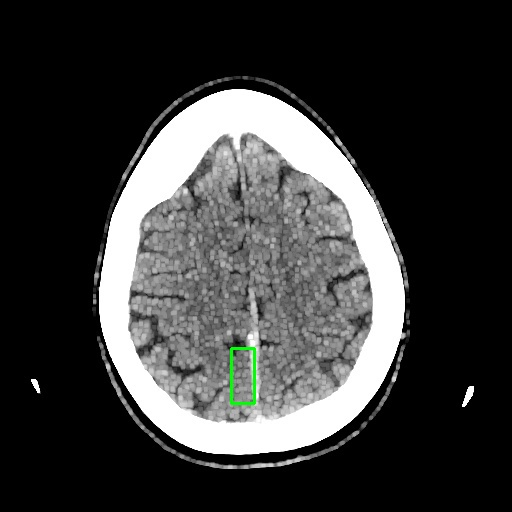

In [98]:
split_ds["test"][0]["image"]

In [90]:
processor

BlipProcessor:
- image_processor: BlipImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "BlipImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "BlipProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

- tokenizer: BertTokenizerFast(name_or_path='Salesforce/blip-image-captioning-base', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=Fals

In [93]:
from huggingface_hub import notebook_login

notebook_login()

In [94]:
trainer.push_to_hub("blip-MedTrinity-peft-1")

events.out.tfevents.1751866700.9cb0eddbcbad.35.8:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

events.out.tfevents.1751867045.9cb0eddbcbad.35.9:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/9.46M [00:00<?, ?B/s]

events.out.tfevents.1751866409.9cb0eddbcbad.35.7:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

events.out.tfevents.1751867083.9cb0eddbcbad.35.10:   0%|          | 0.00/6.47k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Logistic12/results/commit/ef5a0faf05661920bbf469fd00ee79320bbc0fa2', commit_message='blip-MedTrinity-peft-1', commit_description='', oid='ef5a0faf05661920bbf469fd00ee79320bbc0fa2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Logistic12/results', endpoint='https://huggingface.co', repo_type='model', repo_id='Logistic12/results'), pr_revision=None, pr_num=None)